In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import model_from_json
from tqdm import tqdm
import h5py
from data_prep import one_hot_decode

timesteps = 16
cardinality = 131
latent_dim = 64
avg_song_len = 113

Using TensorFlow backend.


### Some details

The MDN will predict sequences of bars, and the sequences must be equal. Therefore, some preparation must be done. Some songs in the dataset are long and some songs are short, this calls for some decisions to be made.  
  
Here's the solution:  
An [average song length](url=https://www.statcrunch.com/5.0/viewreport.php?groupid=948&reportid=28647) is 226 seconds.  
  
The [average bpm](url=https://learningmusic.ableton.com/make-beats/tempo-and-genre.html) for a song is 120. 

The [semiquaver length](url=http://bradthemad.org/guitar/tempo_explanation.php) is 15 / bpm.  
  
15 / 120 = 0.125 seconds per semiquaver  
0.125 * 16 notes per vector = 2 seconds per bar   
226 / 2 = 113 bars per song.  
 
  
#### But first, let's remove empty lists and too long songs.

In [2]:
song_lengths = []
for path, dirs, files in os.walk("songs_encoder_inputs"):
    for file in files:
        song_len = len(np.load(path + os.sep + file))
        
        # Removing songs shorter than one bar
        if song_len == 0: 
            os.remove(path + os.sep + file)
            print("Removing empty list.")
            
        elif song_len > 3 * avg_song_len:
            os.remove(path + os.sep + file)
            print("Song too long. {} bars. Removing.".format(song_len))
            
        else: song_lengths.append(song_len)

### Visualize the data

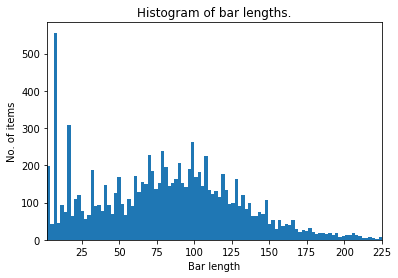

In [3]:
plt.hist(song_lengths,bins=100) 
plt.title("Histogram of bar lengths.")
plt.ylabel("No. of items")
plt.xlabel("Bar length")
plt.xlim(min(song_lengths),max(song_lengths))
plt.show()

## Loading model and weights

In [4]:
# load json and create model
json_file = open('models/encoder_512_64.json', 'r')
loaded_infenc = json_file.read()
json_file.close()

infenc = model_from_json(loaded_infenc)

# load weights into new model
infenc.load_weights("models/encoder_512_64.h5")
print("Loaded infenc model and weights from disk")


json_file = open('models/decoder_512_64.json', 'r')
loaded_infdec = json_file.read()
json_file.close()

infdec = model_from_json(loaded_infdec)

# load weights into new model
infdec.load_weights("models/decoder_512_64.h5")
print("Loaded infdec model and weights from disk")

Loaded infenc model and weights from disk
Loaded infdec model and weights from disk


### Get no of files

In [ ]:
path, dirs, files = next(os.walk("songs_encoder_inputs"))
file_count = len(files)

file_count

9786

### Check the data

In [ ]:
# one song file
f = np.load("songs_encoder_inputs/id-0.npy")

print("Shape of first song file: ", f.shape)
print("No. of slices: ", f.shape[0])
print("Timesteps: ", f.shape[1])
print("One encoded note: ", f[0][0])
print("One decoded bar :", one_hot_decode(f[31]))

Shape of first song file:  (54, 16, 131)
No. of slices:  54
Timesteps:  16
One encoded note:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
One decoded bar : [60, 129, 62, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]


### Define function to get z-list from song

In [ ]:
# generate target given source sequence
def create_z_array(infenc, song, latent_dim):
    z_list = []
    
    for bar in song:
        
        bar = bar.reshape(1, timesteps, cardinality)
        
        # encode
        encoder_output = infenc.predict(bar)

        z = encoder_output[2]
        z = z.reshape(1, 1, latent_dim)
        z_list.append(z)
    
    return np.array(z_list)

### Create the z-dataset

(This takes time)

In [ ]:
h5f = h5py.File('z_dataset.h5', 'w')

for i in tqdm(range(file_count)):
    
    song_from_file = np.load("songs_encoder_inputs/id-" + str(i) + ".npy")
    song_len = song_from_file.shape[0]
    
    # reshaping to work as input to lstm
    song = np.array(song_from_file).reshape(song_len, timesteps, cardinality)
    
    # predicting list of z's
    z_array = create_z_array(infenc, song, latent_dim)
    
    # appending list of z's to dataset
    h5f.create_dataset("z_list" + str(i), data=z_array)
    
h5f.close()

  0%|          | 4/9786 [00:08<5:31:21,  2.03s/it]/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
  6%|▌         | 609/9786 [16:49<4:13:25,  1.66s/it]

### Slice the z's into the required sequence lenght for the MDN